<span style="color:red"><b>Please note: you do not have to understand the content of this notebook yet. The rest of the course will walk you through the details. This introduction is here in case you are undecided which framework you would like to use and to serve as a reference material for operations that we will use frequently.</b></span>

# Getting started

The [Forest SDK](http://docs.rigetti.com/en/stable/) is a comprehensive suite of a language allowing you to define circuits, a simulator, a collection of quantum algorithms, among other important components. For setting it up on your computer, please refer to the Forest documentation. At the time of writing, the simulator and the compiler were not open source. Here we spell out the details of Forest that are critical for the rest of the notebooks.

To run the Forest SDK locally, you must have the Quantum Virtual Machine and the Quil Compiler running as servers on your computer. It is better to run them from the terminal, but for convenience, we can launch them from this notebook if they are in the system path. We have to make sure that the ports we are using are available. We wrap this boilerplate code in a function that returns the process objects and a `ForestConnection` object containing the details of the ports.

In [2]:
#This cell only for package version control
import sys
import pyquil
import matplotlib
import numpy
print('python:     ', sys.version)
print('pyquil:     ', pyquil.__version__)
print('numpy:      ', numpy.__version__)
print('matplotlib: ', matplotlib.__version__)


python:      3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
pyquil:      2.28.0
numpy:       1.20.2
matplotlib:  3.4.1


In [3]:
import socket
import subprocess
from pyquil.api import ForestConnection

def get_free_port():
    sock = socket.socket()
    sock.bind(('', 0))
    port = sock.getsockname()[1]
    sock.close()
    return port

def init_qvm_and_quilc(qvm_executable="qvm", quilc_executable="quilc"):
    qvm_port = get_free_port()
    quilc_port = get_free_port()
    qvm_server = subprocess.Popen([qvm_executable, "-S", "-p", str(qvm_port)])
    quilc_server = subprocess.Popen([quilc_executable, "-R", "-p", str(quilc_port)])
    fc = ForestConnection(sync_endpoint='http://127.0.0.1:' + str(qvm_port), 
                          compiler_endpoint='tcp://127.0.0.1:' + str(quilc_port))
    return qvm_server, quilc_server, fc

We saved this boilerplate code in a file called `forest_tools.py`, so next time we can just import it. Next we launch the servers:

In [4]:
from forest_tools import *
qvm_server, quilc_server, fc = init_qvm_and_quilc('qvm','quilc' )


The tools related to defining quantum circuits, handling the compiler, the simulator, or the quantum processor are in a package called PyQuil. The simulator and the compiler are run as an external services. The most basic component is a Program, which describes the circuit.

In [5]:
from pyquil import Program

This object allows us to define classical registers, which are also called readouts. Quantum registers are defined on the actual simulator or the quantum prdocessing unit, either of which is instantiated via the `get_qc` function:

In [6]:
from pyquil import get_qc

This simulator has multiple backends, allowing us to do simulations with slightly different purposes, as we will see later.

# Backends

The most straightforward simulator backend -- called Quantum Virtual Machine (QVM) -- does exactly what we would expect: it runs a quantum algorithm and writes the measurement results to classical registers. After running a circuit a few times on the simulator, we can inspect the statistics of the results. We can define the number of qubits as part of instantiating the simulator. Here we instantiate a 1-qubit QVM:

In [7]:
qc = get_qc('1q-qvm', connection=fc)


Let us build the simplest possible circuit that has no gates and only a measurement on a single qubit, writing out the result to a single classical register. The classical register has to be added through the class method `declare` of the `Program` class.

In [8]:
from pyquil.gates import MEASURE
circuit = Program()
ro = circuit.declare('ro', 'BIT', 1)
circuit += MEASURE(0, ro[0])

We execute this circuit on the simulator. To define the number of repeated runs, we call the method `wrap_in_numshots_loop`, specifying the number of runs. Then we call the quantum compiler, which runs as an external service, and finally run it on the QVM, which is also an external service.

In [9]:
circuit.wrap_in_numshots_loop(100)
executable = qc.compile(circuit)
result = qc.run(executable)

We can inspect the statistics of getting 0 and 1:

In [10]:
(result == 0).sum(), (result == 1).sum()

(100, 0)

An easier, although somewhat less flexible way of achieving the same is by letting the simulator perform the measurements:

In [11]:
from pyquil.gates import I
circuit = Program()
result = qc.run_and_measure(circuit, trials=100)
result

{0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

Remember that the qubit registers are always initialized as $|0\rangle$. Not surprisingly, out of a hundred executions, we measure `0` a hundred times. If you executed this on the quantum processor, your measurement outcomes might be sometimes `1`  -- that would be due to noise.

If this was the only simulator backend, we would have a hard time debugging our quantum algorithms. Why? We would have to reconstruct the quantum state based on the measurements we make, which is not a trivial task in general. True, this is the only option we have on the actual hardware, but in a simulator, we have one more possibility: we could actually inspect the simulated quantum state (the wavefunction). PyQuil provides a class for this.

In [12]:
from pyquil.api import WavefunctionSimulator
wf_sim = WavefunctionSimulator(connection=fc)

In this case, we do not have to add measurements, unless the protocol we are implementing uses a measurement in its internal operation. So we can build a circuit without a measurement and inspect the quantum state directly.

In [13]:
circuit = Program()
wavefunction = wf_sim.wavefunction(circuit)
print(wavefunction)

(1+0j)|0>


So in this case, we see it is the $|0\rangle$ state, as opposed to observing just the measurement statistics. This is especially important because the type of measurements we can perform are extremely restricted: technically speaking, we always measure in the computational basis. This means that, for instance, the states $|1\rangle$ and $-|1\rangle$ are indistinguishable based on the measurement statistics.

# Visualization

The Forest SDK does not really offer integrated tools for plotting, but it is easy to create our own functions. All of them are included in `forest_tools.py`. The following function will plot a circuit:

In [14]:
from pyquil import Program
from pyquil.gates import H
from pyquil.latex import to_latex
import matplotlib.pyplot as plt
import numpy as np
import shutil
import subprocess
from tempfile import mkdtemp
%matplotlib inline

def plot_circuit(circuit):
    latex_diagram = to_latex(circuit)
    tmp_folder = mkdtemp()
    with open(tmp_folder + '/circuit.tex', 'w') as f:
        f.write(latex_diagram)
    proc = subprocess.Popen(['pdflatex', '-shell-escape', tmp_folder + '/circuit.tex'], cwd=tmp_folder)
    proc.communicate()
    image = plt.imread(tmp_folder + '/circuit.png')
    shutil.rmtree(tmp_folder)
    plt.axis('off')
    return plt.imshow(image)

The function needs a working LaTeX installation and ImageMagick. Here's an example circuit and its diagram:

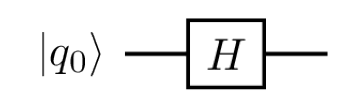

In [15]:
circuit = Program()
circuit += H(0)
plot_circuit(circuit)

This gives a quick sanity check to see whether we correctly implemented some circuit.

The second helper function shows the operation on the Bloch sphere, which is especially important for understanding how rotations happen. We borrowed this function from [this tutorial](https://github.com/markf94/rigetti_training_material) and it requires QuTiP. This visualization method relies on the wavefunction simulator.

In [16]:
import cmath
from qutip import Bloch

def get_vector(alpha, beta):
    """
    Function to compute 3D Cartesian coordinates
    from 2D qubit vector.
    """

    # get phases
    angle_alpha = cmath.phase(alpha)
    angle_beta = cmath.phase(beta)

    # avoiding wrong normalization due to rounding errors
    if cmath.isclose(angle_alpha, cmath.pi):
        angle_alpha = 0
    if cmath.isclose(angle_beta, cmath.pi):
        angle_beta = 0
        
    if (angle_beta < 0 and angle_alpha < angle_beta) or (angle_beta > 0 and angle_alpha > angle_beta):
            denominator = cmath.exp(1j*angle_beta)
    else:
            denominator = cmath.exp(1j*angle_alpha)

    # eliminate global phase
    alpha_new = alpha/denominator
    beta_new = beta/denominator

    # special case to avoid division by zero
    if abs(alpha) == 0 or abs(beta) == 0:
        if alpha == 0:
            return [0,0,-1]
        else:
            return [0,0,1]
    else:
        # compute theta and phi from alpha and beta
        theta = 2*cmath.acos(alpha_new)
        phi = -1j*cmath.log(beta_new/cmath.sin(theta/2))

        # compute the Cartesian coordinates
        x = cmath.sin(theta)*cmath.cos(phi)
        y = cmath.sin(theta)*cmath.sin(phi)
        z = cmath.cos(theta)

    return [x.real,y.real,z.real]

def plot_quantum_state(amplitudes):
    """
    Thin function to abstract the plotting on the Bloch sphere.
    """
    bloch_sphere = Bloch()
    vec = get_vector(amplitudes[0], amplitudes[1])
    bloch_sphere.add_vectors(vec)
    bloch_sphere.show()
    bloch_sphere.clear()

 For instance, let's compare the initial state $|0\rangle$ and the Hadamard gate applied to it:

/opt/conda/lib/python3.8/site-packages/qutip/bloch.py:451: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
/opt/conda/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


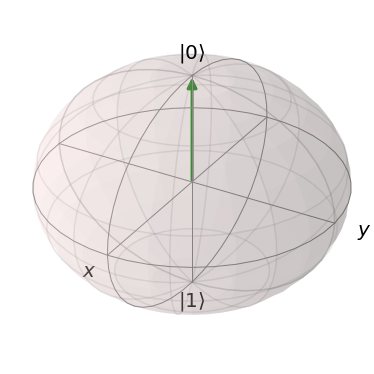

In [17]:
from pyquil.api import WavefunctionSimulator
from pyquil.gates import I

wf_sim = WavefunctionSimulator(connection=fc)

circuit = Program()
circuit += I(0)
wavefunction = wf_sim.wavefunction(circuit)
plot_quantum_state(wavefunction.amplitudes)

After the Hadamard gate:

/opt/conda/lib/python3.8/site-packages/qutip/bloch.py:451: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
/opt/conda/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


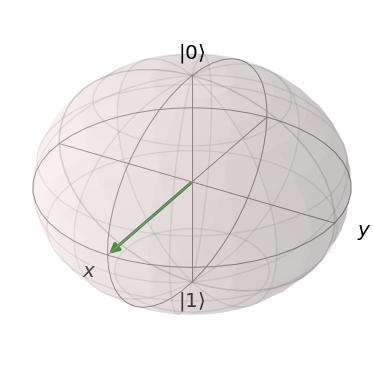

In [18]:
circuit += H(0)
wavefunction = wf_sim.wavefunction(circuit)
plot_quantum_state(wavefunction.amplitudes)

The third way of visualizing what happens is plotting the statistics of measurement results. Arguably, this is the most important for practical applications and debugging. We define a function for this:

In [19]:
import itertools

def plot_histogram(result):
    if isinstance(results, dict):
        tmp=[]
        tmp.append([results[i] for i in range(len(results))])
        outcomes = np.flip(np.vstack(tmp).T)
    else:
        outcomes = results
    trials, classical_bits = outcomes.shape
    stats = {}
    for bits in itertools.product('01', repeat=classical_bits):
        stats["".join(str(bit) for bit in bits)] = 0
    for i in range(trials):
        stats["".join(str(bit) for bit in outcomes[i])] += 1
    x = np.arange(len(stats))
    plt.bar(x, stats.values())
    plt.xticks(x, stats.keys())
    plt.show()

Here are the statistics before the Hadamard gate:

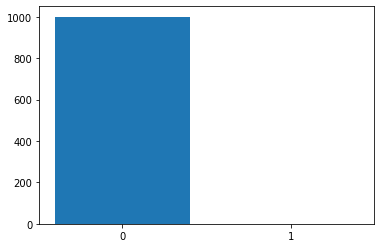

In [20]:
circuit = Program()
circuit += I(0)
results = qc.run_and_measure(circuit, trials=1000)
plot_histogram(results)

After the Hadamard gate:

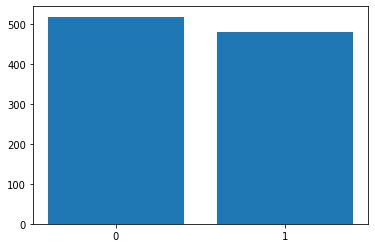

In [21]:
circuit += H(0)
results = qc.run_and_measure(circuit, trials=1000)
plot_histogram(results)

As we can see, the 'perfect' nature of the simulator is reflected again in getting all 0s for the initial state, and a distribution very close to uniform after applying the Hadamard gate. In a longer circuit on real quantum hardware, these statistics would be heavily affected by noise.

Finally, we can terminate the qvm and quilc servers:

In [22]:
qvm_server.terminate()
quilc_server.terminate()